# Introducing Convolutional Neural Networks

#### The following topics will be covered in this chapter:

* The problem with traditional deep neural networks

* Building blocks of a CNN

* Implementing a CNN

* Classifying images using deep CNNs

* Implementing data augmentation

* Visualizing the outcome of feature learning

* Building a CNN for classifying real-world images

# The problem with traditional deep neural networks

In [1]:
from torchvision import datasets
import torch
data_folder = 'Dataset' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:25<00:00, 1018384.77it/s]


Extracting Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 308569.21it/s]


Extracting Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1039096.40it/s]


Extracting Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4222189.48it/s]


Extracting Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [7]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


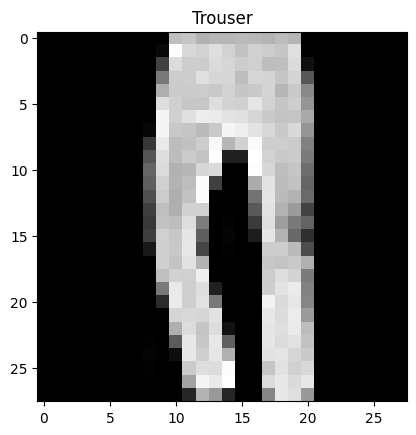

In [11]:
# 1. Fetch a random image from the available training images
ix = 24300
plt.imshow(tr_images[ix],cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])
plt.show()

In [13]:
# 2. Pass the image through the trained mode
## Preprocess the image so it goes through the same pre-processing steps we performed while building the model
img = tr_images[ix]/255
img = img.view(28*28)
img = img.to(device=device)

## Extract the probabilities associated with the various classes 
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.2273968e-03, 9.9873716e-01, 8.0490327e-07, 1.9276174e-05,
       8.3644034e-07, 5.7215500e-12, 1.4509570e-05, 9.1665482e-16,
       3.8547906e-08, 2.1145303e-12], dtype=float32)

###### we can see that the highest probability is for the 1st index, which is of the Trouser class.

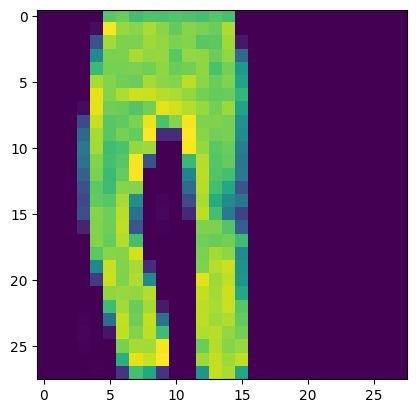

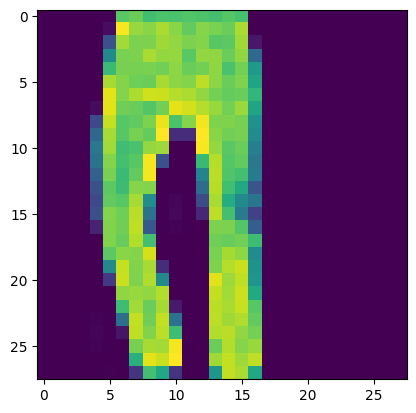

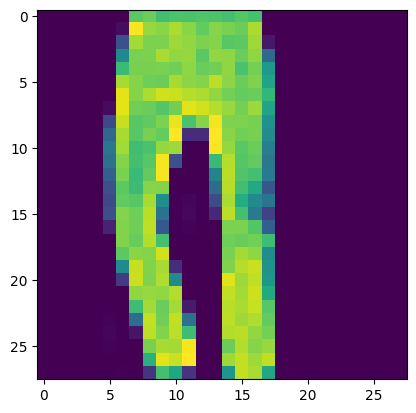

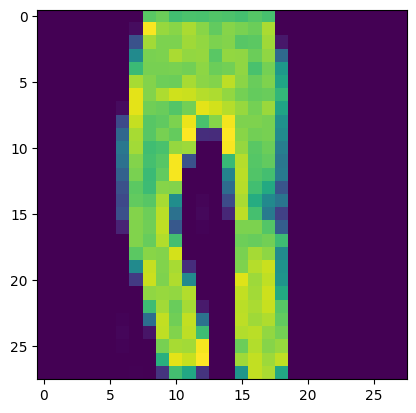

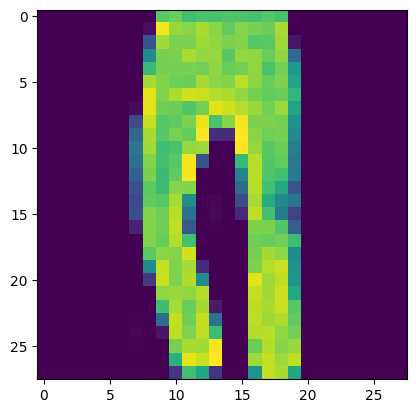

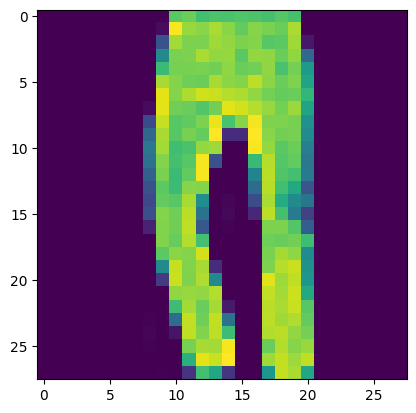

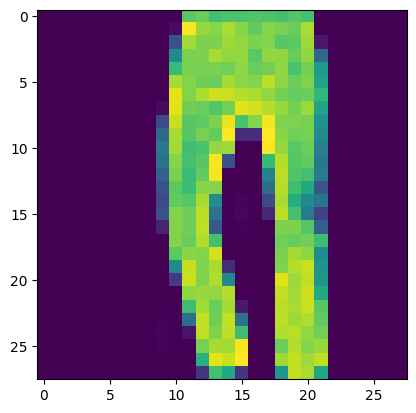

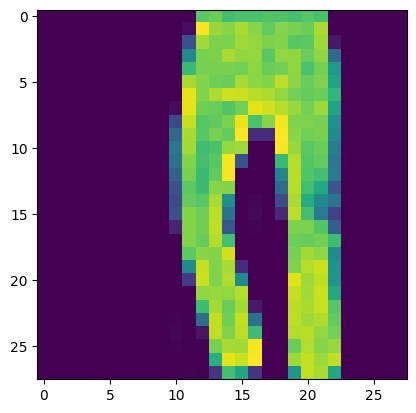

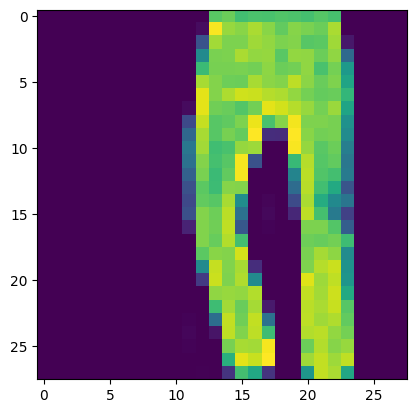

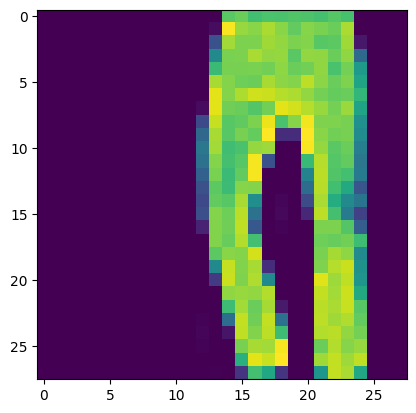

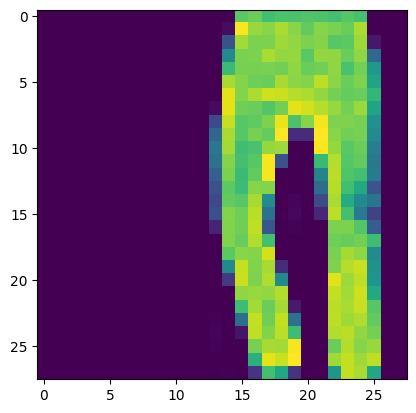

In [15]:
# 3. Translate (roll/slide) the image multiple times (one pixel at a time) from a translation of 5 pixels to the left to 5 pixels to the right and store the predictions in a list.
## Create a list that stores predictions
preds = []

## Create a loop that translates (rolls) an image from -5 pixels (5 pixels to the left) to +5 pixels (5 pixels to the right) of the original position (which is at the center of the image)
for px in range(-5,6):
  # Pre-process the image
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))

  # Roll the image by a value equal to px within the for loop
  img2 = np.roll(img, px, axis=1) # we specified axis=1 since we want the image pixels to be moving horizontally 
  plt.imshow(img2)
  plt.show()
  
  # Store the rolled image as a tensor object and register it to device:
  img3 = torch.Tensor(img2).view(28*28).to(device)
  
  # Pass img3 through the trained model to predict the class of the translated (rolled) image and append it to the list that is storing predictions for various translations
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

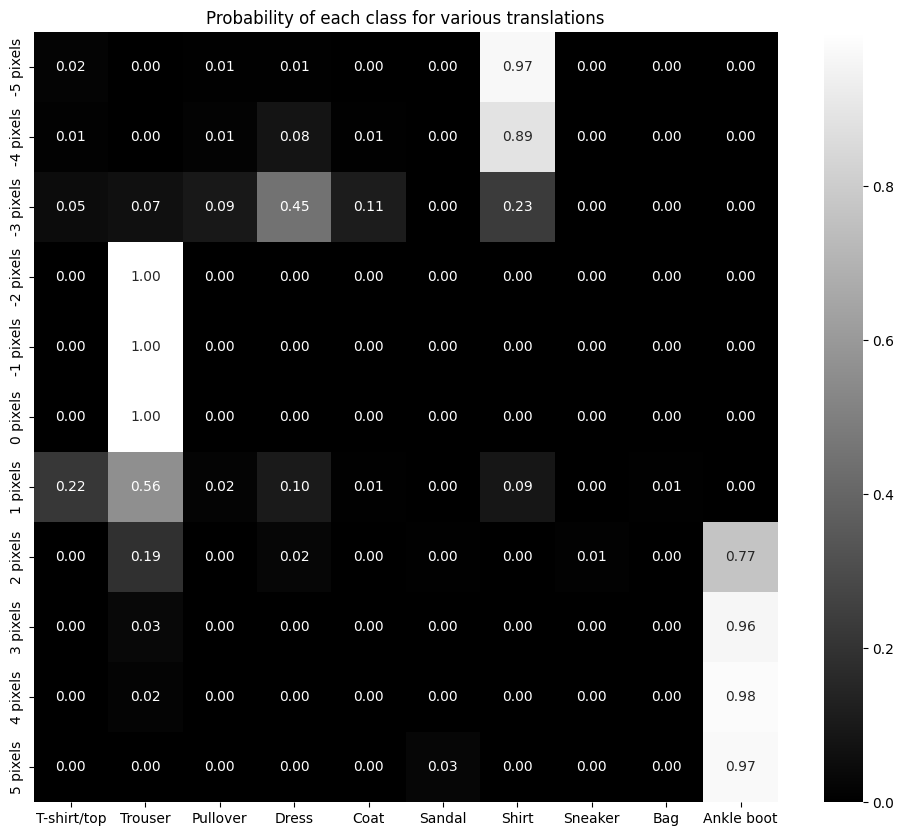

In [16]:
# 4. Visualize the predictions of the model for all the translations (-5 pixels to +5 pixels)
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.show()

* There was no change in the image's content since we only translated the images from 5 pixels to the left and 5 pixels to the right. However, the predicted class of the image changed when the translation was beyond 2 pixels. This is because while the model was being trained, the content in all the training and testing images was at the center. This differs from the preceding scenario where we tested with translated images that are off-center, resulting in an incorrectly predicted class.

    CNNs help address this problem  

---

# Building blocks of a CNN

###### Convolutional Neural Networks (CNNs) are the primary architecture for image-related tasks, overcoming limitations of deep neural networks. They excel in image classification, object detection, image segmentation, GANs, and various other image-related applications. CNNs offer diverse construction methods and numerous pre-trained models, making them crucial in various tasks involving images.

##### building blocks of a CNN, which are as follows:
* Convolutions
* Filters
* Strides and padding
* Pooling

## Convolutions


###### A convolution is basically multiplication between two matrices. As you saw in the previous chapter, matrix multiplication is a key ingredient of training a neural network. 


$$Image =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}
Filter
\quad
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}
$$


- While performing the convolution operation, you are sliding `Filter or a Kernel` over `Original image`.  

- we are performing element to element multiplication between `Kernel` and `Original image`, as follows:

  -  1. Multiply {1,2,5,6} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 1 * 1 + 2 * 2 + 5 * 3 + 6 * 4 = 44


  -  2. Multiply {2,3,6,7} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 2 * 1 + 3 * 2 + 6 * 3 + 7 * 4 = 54


  -  3. Multiply {3,4,7,8} of the `Original image`  by {1,2,3,4} of the `Filter` :
  3 * 1 + 4 * 2 + 7 * 3 + 8 * 4 = 64


  -  4. Multiply {5,6,9,10} of the `Original image`  by {1,2,3,4} of the `Filter` :
  5 * 1 + 6 * 2 + 9 * 3 + 10 * 4 = 84


  -  5. Multiply  {6,7,10,11} of the `Original image`  by {1,2,3,4} of the `Filter` :
  6 * 1 + 7 * 2 + 10 * 3 + 11 * 4 = 94


  -  6. Multiply {7,8,11,12} of the `Original image`  by {1,2,3,4} of the `Filter` :
  7 * 1 + 8 * 2 + 11 * 3 + 12 * 4 = 104


  -  7. Multiply {9,10,13,14} of the `Original image`  by {1,2,3,4} of the `Filter` :
    9 * 1 + 10 * 2 + 13 * 3 + 14 * 4 = 124


  -  8. Multiply {10,11,14,15}  of the `Original image`  by {1,2,3,4} of the `Filter` :
  10 * 1 + 11 * 2 + 14 * 3 + 15 * 4 = 134


  -  9. Multiply {11,12,15,16} of the `Original image`  by {1,2,3,4} of the `Filter` :
  11 * 1 + 12 * 2 + 15 * 3 + 16 * 4 = 144


**The result of performing the preceding operations is as follows:**
$$
Convolutions Output
\begin{bmatrix}
44 & 54 & 64 \\
84 & 94 & 104 \\
124 & 134 & 144 \\
\end{bmatrix}
$$


## Filter

###### A filter is a matrix of weights that is initialized randomly at the start. The model learns the optimal weight values of a filter over increasing epochs.

- CNN Filters & Image Features:
  - More filters in a CNN allow the model to learn different features in an image.
  - Each filter identifies specific features (e.g., a cat's ears) and yields higher activation when the image area matches that feature.


- Convolution Output:
  - Applying a 2x2 filter to a 4x4 matrix produces a 3x3 output.
  - Utilizing 10 different 2x2 filters on the original image results in 10 sets of 3x3 outputs.

- Number of Output Channels:
  - The number of output channels aligns with the number of filters used.
  - For color images (with three channels), both the image and filters possess three channels, resulting in a single scalar output per convolution.

- Intermediate Layer Convolutions:
  - When convolving with an intermediate 64x112x112 output, a filter requires 64 channels to generate a scalar output.
  - Using 512 filters on the intermediate output yields a resulting shape of 512x111x111.

\begin{equation}
n_{out}=\lfloor\frac{n_{in}+2p-k}{s}\rfloor+1
\end{equation}



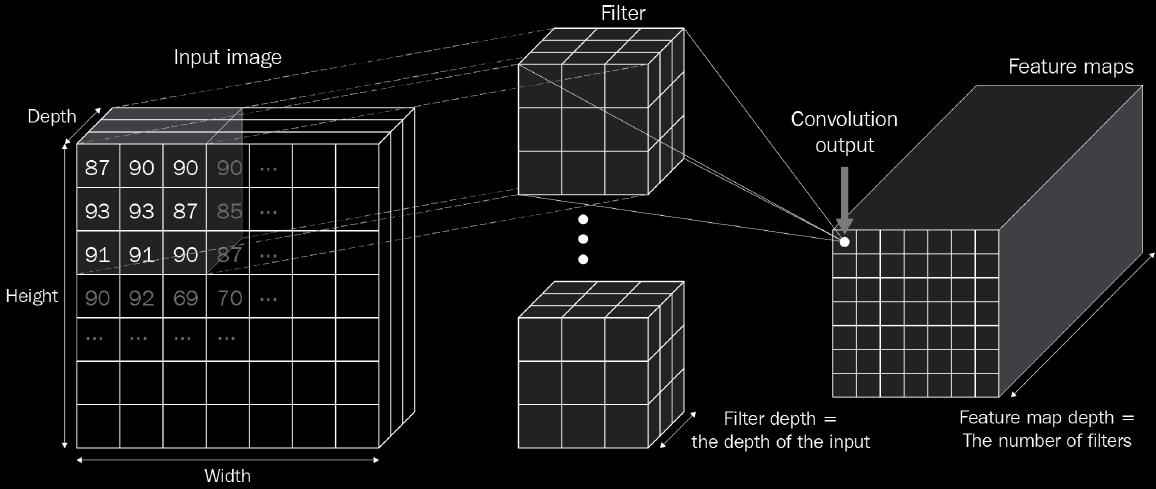

###### the input image is multiplied by the filters that have the same depth as that of the input (which the filters are convolving with) and that the number of channels in the output of a convolution is as many as there are filters.

## Strides


$$Image =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}
Filter
\quad
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}
$$


- We'll stride `Filter or a Kernel` with a stride of 2 over `Original image` 
- The output of convolution with a stride of 2 is as follows:

  - 1. Multiply {1,2,5,6} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 1 * 1 + 2 * 2 + 5 * 3 + 6 * 4 = 44


  - 3. Multiply {3,4,7,8} of the `Original image`  by {1,2,3,4} of the `Filter` :
  3 * 1 + 4 * 2 + 7 * 3 + 8 * 4 = 64


  - 7. Multiply {9,10,13,14} of the `Original image`  by {1,2,3,4} of the `Filter` :
    9 * 1 + 10 * 2 + 13 * 3 + 14 * 4 = 124


  - 9. Multiply {11,12,15,16} of the `Original image`  by {1,2,3,4} of the `Filter` :
  11 * 1 + 12 * 2 + 15 * 3 + 16 * 4 = 144


**The result of performing the preceding operations is as follows:**
$$
Convolutions Output
\begin{bmatrix}
44 & 64 \\
124 & 144 \\
\end{bmatrix}
$$


## Padding

###### In the preceding case, we could not multiply the leftmost elements of the filter by the rightmost elements of the image. If we were to perform such matrix multiplication, we would pad the image with zeros. This would ensure that we can perform element to element multiplication of all the elements within an image with a filter

Once we add padding on top of `Original Image`, the revised version of `Original Image` will look as follows:

$$Image =
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 2 & 3 & 4 & 0\\
0 & 5 & 6 & 7 & 8 & 0\\
0 & 9 & 10 & 11 & 12 & 0\\
0 & 13 & 14 & 15 & 16 & 0\\
0 & 0 & 0 & 0 & 0 & 0 \\ 
\end{bmatrix}
$$
###### From the preceding matrix, we can see that we have padded `Original Image` with zeros and that the convolution with `Filter` will not result in the output dimension being smaller than the input's dimension. This aspect comes in handy when we are working on residual network where we must add the output of the convolution to the original image.

## Pooling

- Pooling aggregates information in a small patch
    - Imagine a scenario where the output
of convolution activation is as follows: 
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}

    - The max pooling for this patch is 4. Here, we have considered the elements in this pool of elements and have taken the maximum value across all the elements present.

    - understand the max pooling for a `Original Image`:
    \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}

    - If the pooling stride has a length of 2, the max pooling operation is calculated as follows, where we divide the input image by a stride of 2
(that is, we have divided the image into 2 x 2 divisions)

    - The maximum values in the pool of elements are as follows:
$$
\begin{bmatrix}
6 & 8 \\
14 & 16 \\
\end{bmatrix}
$$
- Other variants of pooling are sum and average pooling
    However, in practice, max pooling is used more often.
    
- ###### Note that by the end of performing the convolution and pooling operations, the size of the original matrix is reduced from 4 x 4 to 2 x 2. In a realistic scenario, if the original image is of shape 200 x 200 and the filter is of shape 3 x 3, the output of the convolution operation would be 198 x 198. After that, the output of the pooling operation with a stride of 2 is 99 X 99.

## Putting them all together

- the flatten layer (fully connected layer)
    - The output of flattening the pooling layer is as follows:
    {6,8,14,16}

    - Once the flatten layer's (fully connected layer) values have been obtained, we can pass it through the hidden layer and then obtain the output for predicting the class of an image.

**The overall flow of a CNN is as follows:**

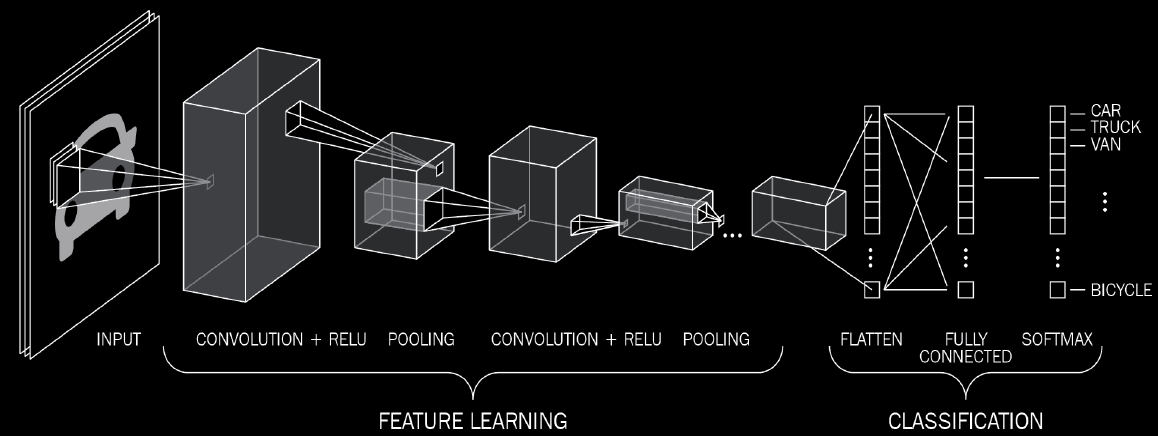

- Convolution and Pooling:
    - Image passed through convolution using multiple filters and pooling.
    - Process may repeat to extract features and reduce dimensionality before flattening.

- Feature Learning:
    - Core operations are convolution and pooling.
    - Filters extract features, while pooling aggregates information, reducing nodes at the flatten layer.
    

- Dimension Reduction:
    - Convolution and pooling lead to a flattened layer that represents the image in a much smaller format than the original.
    - Crucial for manageable computation due to reduced dimensionality.

- Classification Process:
    - Final stage involves classification similar to traditional neural networks.
    - Includes hidden layers and an output layer to classify features extracted in earlier stages.


###### - Directly flattening a large input image without this process results in a vast number of parameters, demanding heavy computation.


---

# How convolution and pooling help in image translation



1. Pooling Abstraction: 
   - Pooling creates an abstracted view of image regions, beneficial for image translation tasks.

2. Effect of Image Translation: 
   - Convolution, activation, and pooling reduce the image's dimension, storing primary information in fewer pixels.

3. Consistency in Pooled Information: 
   - Pooled information within a pixel remains consistent despite image translation, as it captures the maximum value in a given region.

4. Receptive Field in Convolution and Pooling: 
   - Multiple convolution-pooling operations reduce a 100x100 image to a 25x25 output, with each cell in the output corresponding to a 4x4 portion of the original image.


###### because of the convolution and pooling operations, each cell in the resulting image corresponds to a patch of the original image.


----

# Implementing a CNN

###### A CNN is one of the foundational blocks of computer vision techniques, and it is important for you to have a solid understanding of how they work. While we already know that a CNN constitutes convolution, pooling, flattening, and then the final classification layer

---
# Building a CNN-based architecture